In [13]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
from utilities import Data, Plots, Consts
import BgFuncs as bf

from scipy.optimize import curve_fit
# Useful imports and utlities

BINS = 200
NORMALISED = False # TODO: Add implementation to change this
ROI = [4500, 6500]
fits = {'gaussian': [bf.gaussian, [3000, 200]], 'exponential': [bf.exponential, [1, 1, 1, 1]]}
# Setting all constants required

RFNAME, RSUFFIX = Consts().get_real_tuple()
rd = Data(RFNAME, RSUFFIX)
# Setup the real Data object

def bar_with_errs(data, bin_width, labels, figsize=(9, 7), savefig=None, title=None, show=True):
    """
    data is a list of  numpy array such that each row is a data item with the first
    column the y-position and the 2nd column the yerr and the 3rd the x
    """
    if type(data) is not list:
        data = [data]
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    for i, dat in enumerate(data):
        ax.bar(dat[:,2], dat[:,0], yerr=dat[:,1], width=bin_width, label=labels[i], edgecolor='k')
    ax.set_xlabel('Mass (MeV)')
    ax.set_ylabel('Frequency')
    if title is not None:
        plt.title(title)
    plt.legend(frameon=False)
    if show == True:
        plt.show()
    else:
        plt.close()
    if savefig is not None:
            plt.savefig(savefig)
    return fig, ax

In [11]:
df = rd.fetch_features(['Lb_M'])
print('UPDATE: Fetched the invariant masses')
masses = df['Lb_M'].to_numpy()
# Get the invariant mass, as calculated by ROOT

UPDATE: Fetched the invariant masses


In [12]:
bin_space = np.linspace(int(np.floor(np.min(masses))), int(np.ceil(np.max(masses))), BINS+1)
# Create a uniformly distributed array of bin edge positions between the rounded min/max of masses

bin_centres = [(bin_space[i] + bin_space[i+1])/2 for i in range(len(bin_space) - 1)]
bin_width = np.mean([(bin_space[i+1] - bin_space[i]) for i in range(len(bin_space)-1)])
print('UPDATE: Finished calculating the bin-space, bin width and bin centroids')
# Calculate the centres of each bin and the width of each bin
    
frequencies, _ = np.histogram(masses, bin_space, density=NORMALISED)
# Use numpy to bin the data using the bin space we calculated, this is not normalised
errors = np.sqrt(frequencies) 
# Error on the bin is proportional to the sqrt of the counts
print('UPDATE: Data binned and errors on bins calculated')

data = np.array([frequencies, errors, bin_centres]).T
# Combine the data into a big array so applying mass cuts is easier

data = data[data[:,2] >= ROI[0], :]
data = data[data[:,2] <= ROI[1], :]
# Remove all bins where the centroid is outside the region of interest

data = data[~np.any(data == 0, axis=1)]
# Remove all the bins where the bin is empty, typically the blinded region

UPDATE: Finished calculating the bin-space, bin width and bin centroids
UPDATE: Data binned and errors on bins calculated


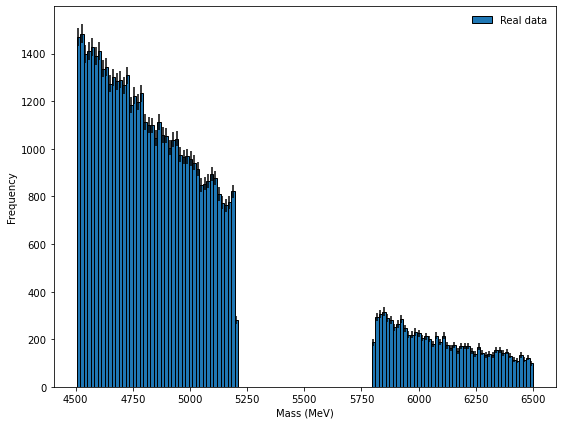

In [14]:
fig, ax = bar_with_errs(data, bin_width, ['Real data'])

/cvmfs/lhcbdev.cern.ch/conda/envs/default/2021-09-07_04-06/linux-64/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


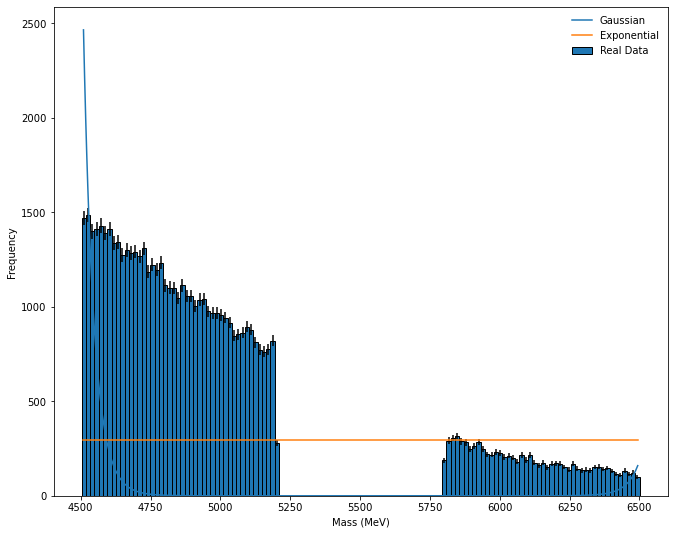

<Figure size 432x288 with 0 Axes>

In [16]:
for function_name, function_and_p0 in fits.items():
    popt, pcov = curve_fit(function_and_p0[0], data[:,2], data[:,0], p0=function_and_p0[1], sigma=data[:,1])
    # Use a chi-square fitting routine first, this is the same as a least squares but with errors
    fits[function_name] = [function_and_p0[0], popt]
    # Update the initial guess parameters to the optimised paramters

func_plot_range = np.linspace(int(np.floor(np.min(data[:,2]))), int(np.ceil(np.max(data[:,2]))), 500)
# Define a range to plot the function over

fig, ax = plt.subplots(1, 1, figsize=(11, 9))
ax.bar(data[:,2], data[:,0], yerr=data[:,1], edgecolor='k', width=bin_width, label='Real Data')
for function, params in fits.items():
    ax.plot(func_plot_range, params[0](func_plot_range, *params[1]), label=f'{function.capitalize()}')
ax.set_ylabel('Frequency')
ax.set_xlabel('Mass (MeV)')
plt.legend(frameon=False)
plt.show()
plt.savefig('/home/user211/project/images/bgfits/optimised_fits_chisquare_bad.png', dpi=700)